# Sex-specific cardiac disease classifiers

#### Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import keras_tuner as kt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

## DATA

#### Data import and some pre-processing

In [2]:
csv_file = 'HeartDiseaseLarge.csv'
dataframe = pd.read_csv(csv_file)

dataframe = dataframe.drop(columns = ['eid']) # Drop the eid, disease lists, and old disease vs. healthy coding
features = dataframe.copy()
n_patients = len(features.index) # Number of all patients

features

,Sex,Age,Ventricular rate,P duration,PP interval,PQ interval,QRS number,QRS duration,QT interval,QTC interval,...,End systolic pressure index during PWA,Mean arterial pressure during PWA,Number of beats in waveform average for PWA,Peripheral pulse pressure during PWA,Stroke volume during PWA,Systolic brachial blood pressure during PWA,HeartDisease,HypertensiveDiseases,IschaemicHeartDiseases,ConductionDisorders
0,0,63.0,78.0,116.0,765.0,232.0,13.0,86.0,376.0,428.0,...,0.625,89.5,17.5,56.0,79.5,124.0,0,0,0,0
1,0,58.0,67.0,72.0,895.0,172.0,9.0,80.0,388.0,409.0,...,0.720,106.0,13.0,83.0,147.0,158.0,1,1,0,0
2,0,66.0,60.0,104.0,1000.0,194.0,10.0,76.0,412.0,412.0,...,0.680,91.0,13.5,67.0,125.5,131.0,0,0,0,0
3,0,64.0,50.0,64.0,1200.0,168.0,8.0,96.0,418.0,381.0,...,0.640,97.0,12.0,96.0,182.0,162.0,1,1,0,0
4,1,59.0,65.0,74.0,920.0,172.0,10.0,100.0,418.0,434.0,...,0.760,87.0,15.0,72.0,99.5,132.0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,0,58.0,71.0,104.0,845.0,150.0,12.0,80.0,414.0,449.0,...,0.635,74.0,12.5,107.0,181.5,143.0,0,0,0,0
24258,0,71.0,71.0,110.0,845.0,156.0,12.0,76.0,400.0,434.0,...,0.755,88.0,13.5,66.0,109.0,126.0,0,0,0,0
24259,0,74.0,70.0,110.0,855.0,182.0,11.0,92.0,410.0,442.0,...,0.695,113.0,16.0,105.0,185.0,172.0,1,1,0,0
24260,1,64.0,52.0,100.0,1150.0,176.0,9.0,92.0,446.0,414.0,...,0.785,92.0,12.0,96.0,171.0,152.0,1,1,1,0


Plot some relations of the features to the disease

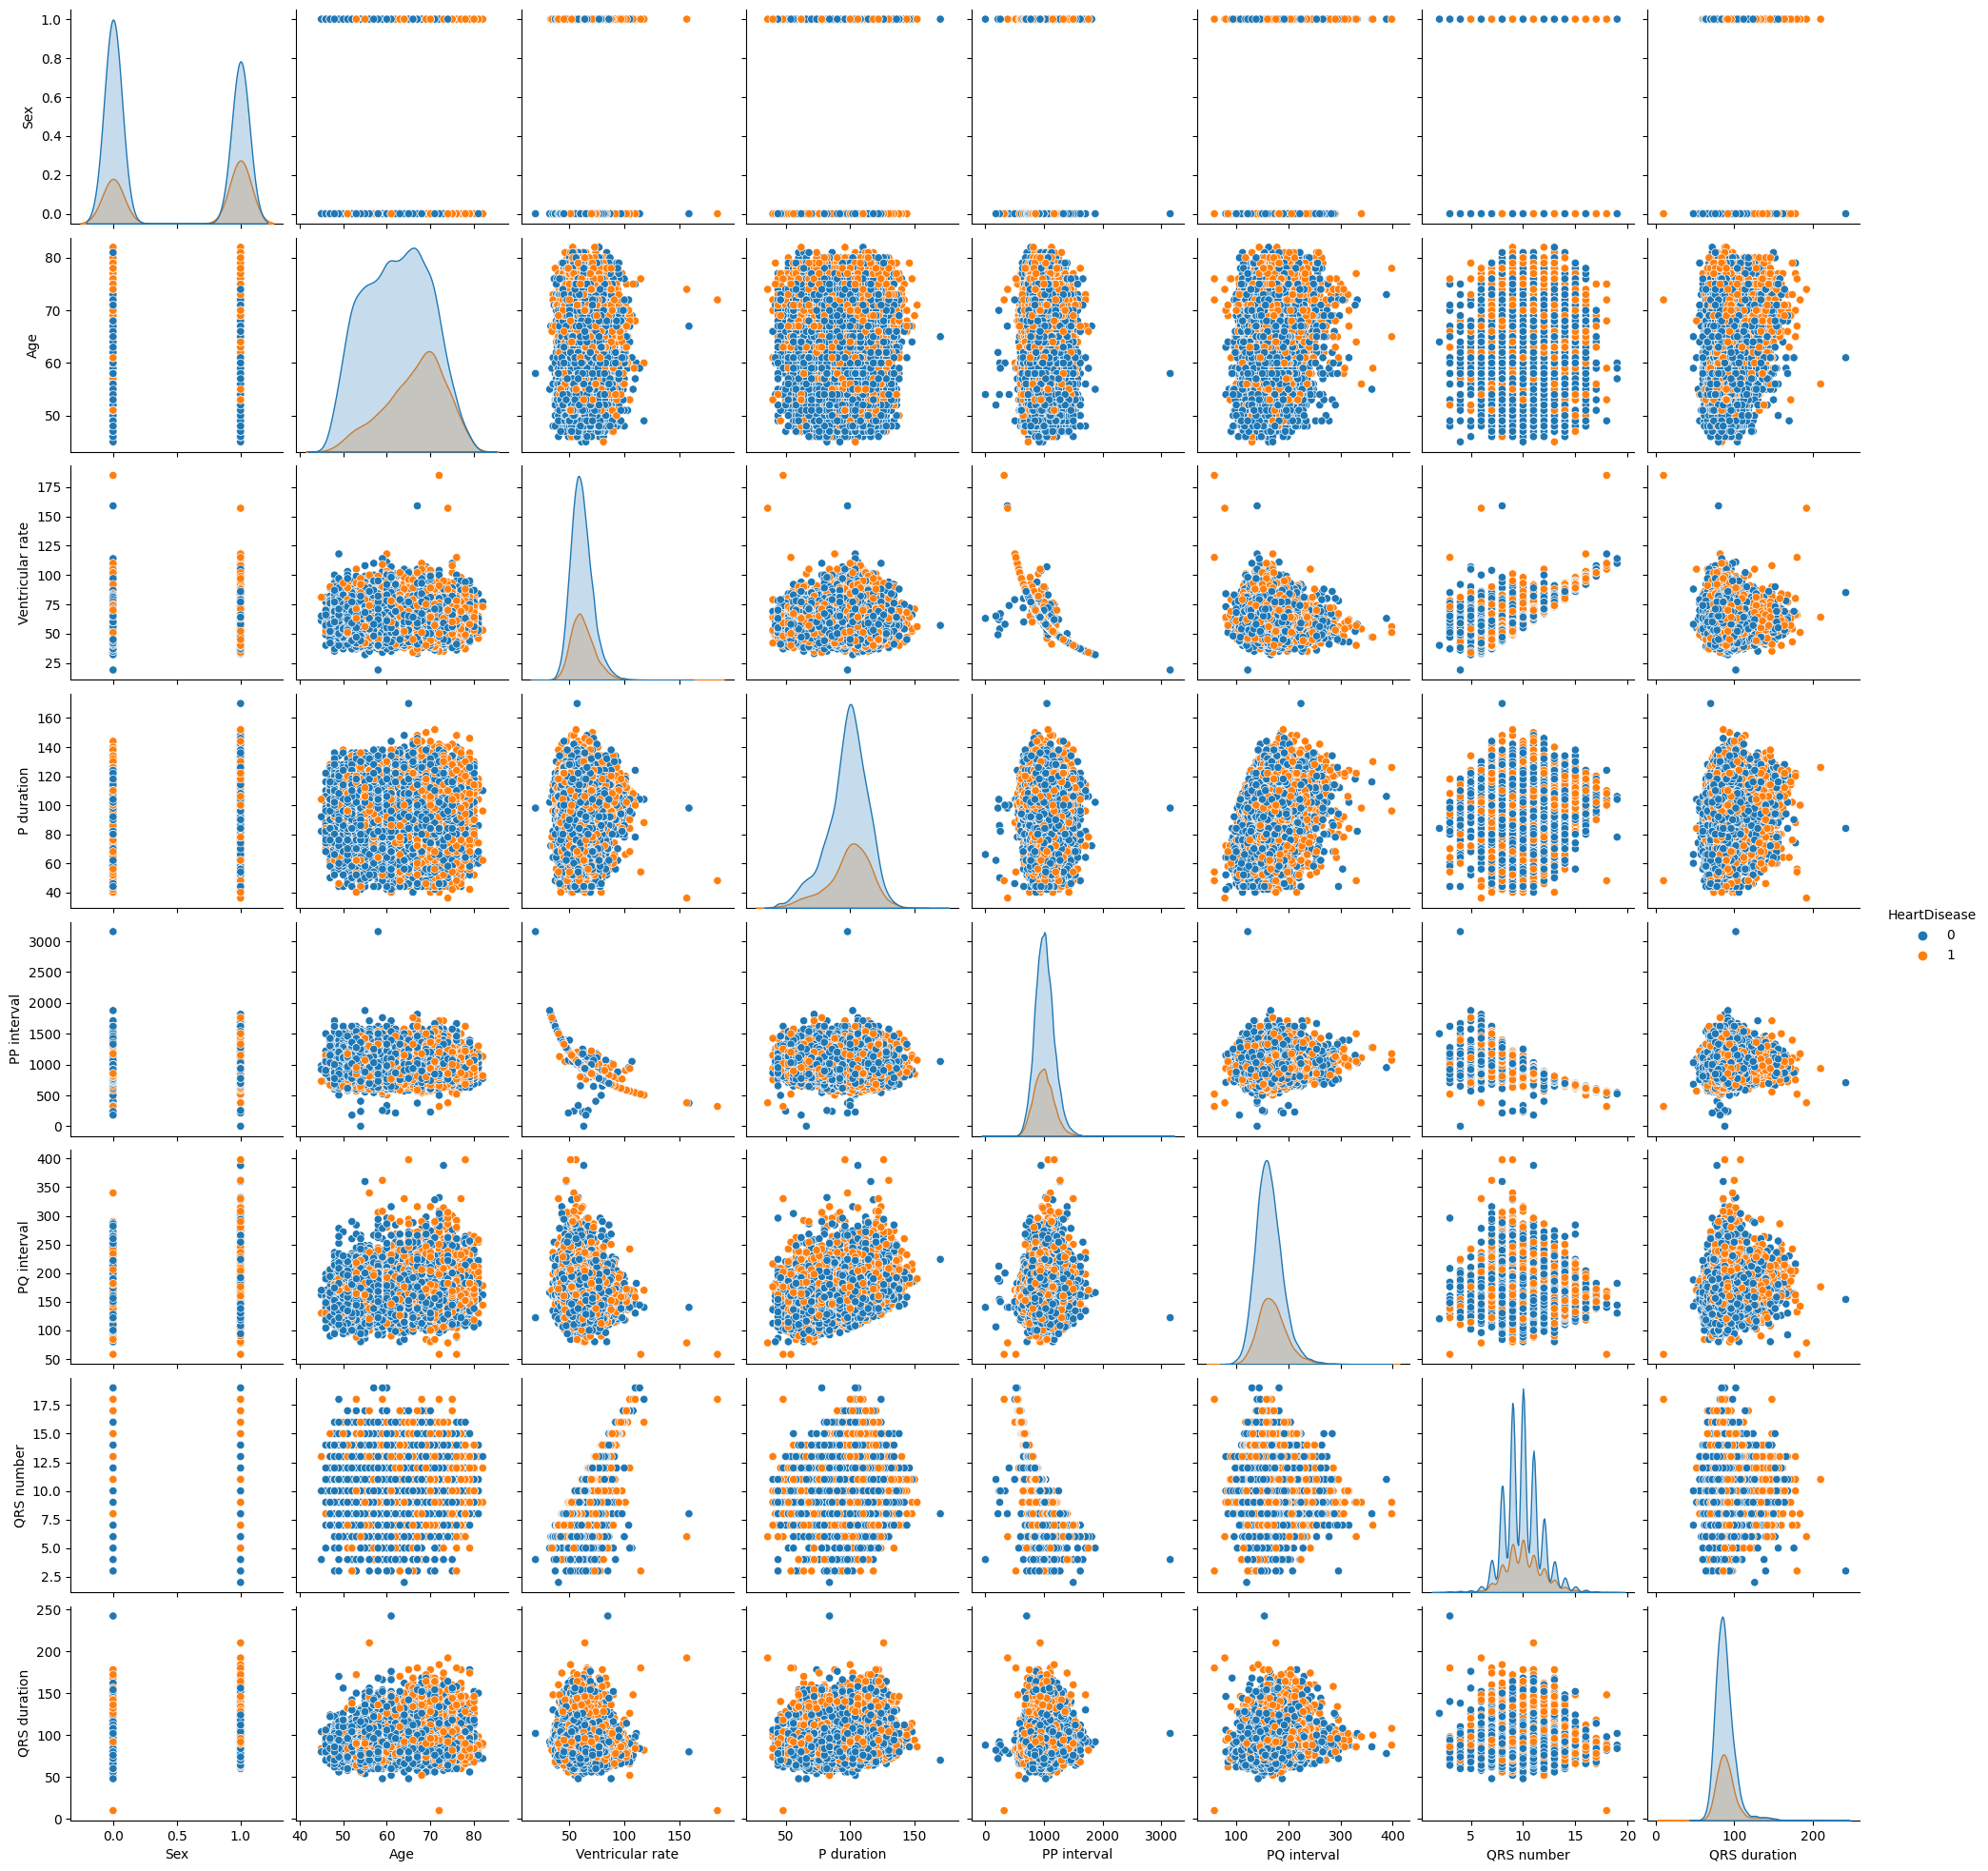

In [5]:
sns.pairplot(dataframe.iloc[:, np.r_[-4, 0:8]], hue = 'HeartDisease', diag_kind='kde');

In [3]:
target = features.pop('HeartDisease') # OUTPUT
target

0        0
1        1
2        0
3        1
4        1
        ..
24257    0
24258    0
24259    1
24260    1
24261    0
Name: HeartDisease, Length: 24262, dtype: int64

In [4]:
tf.convert_to_tensor(features) # INPUT features (tensor)

<tf.Tensor: shape=(24262, 56), dtype=float64, numpy=
array([[ 0., 63., 78., ...,  0.,  0.,  0.],
       [ 0., 58., 67., ...,  1.,  0.,  0.],
       [ 0., 66., 60., ...,  0.,  0.,  0.],
       ...,
       [ 0., 74., 70., ...,  1.,  0.,  0.],
       [ 1., 64., 52., ...,  1.,  1.,  0.],
       [ 1., 66., 64., ...,  0.,  0.,  0.]])>

Standarization

In [5]:
# Define the feature normalizer layer
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(features)

normalizer(features.iloc[:3]) # Normalization sanity check

<tf.Tensor: shape=(3, 56), dtype=float32, numpy=
array([[-0.9615814 , -0.04756948,  1.6477592 ,  1.1101567 , -1.4621608 ,
         2.5423927 ,  1.7352417 , -0.19729063, -1.4017419 ,  0.3221979 ,
        -1.4307009 ,  1.5010676 ,  1.9351369 ,  1.2330407 ,  0.5320181 ,
        -0.74563843, -0.5628449 , -0.95998955, -0.21780676, -0.51573116,
        -0.37490568, -0.81427014, -0.89082634,  0.04199839, -0.06702897,
        -0.6185491 ,  0.63835776, -0.85259444, -0.58693206,  1.9431858 ,
        -0.0469137 , -0.28460607, -0.16789755,  1.9078165 , -1.5081458 ,
         0.8890092 ,  0.05800499,  1.1203765 , -0.6999744 , -0.50749636,
        -0.8534267 , -0.43197083, -0.63294804, -0.65236735, -0.656552  ,
        -0.12382825, -0.75160325, -0.9298189 , -0.4642494 ,  1.8972998 ,
        -0.63795817, -0.9772037 , -0.64836746, -0.49249274, -0.26960298,
        -0.22930653],
       [-0.9615814 , -0.710842  ,  0.564642  , -1.6111805 , -0.66487944,
         0.28426552, -0.55749685, -0.64125973, -1.017

In [6]:
features

,Sex,Age,Ventricular rate,P duration,PP interval,PQ interval,QRS number,QRS duration,QT interval,QTC interval,...,End systolic blood pressure during PWA,End systolic pressure index during PWA,Mean arterial pressure during PWA,Number of beats in waveform average for PWA,Peripheral pulse pressure during PWA,Stroke volume during PWA,Systolic brachial blood pressure during PWA,HypertensiveDiseases,IschaemicHeartDiseases,ConductionDisorders
0,0,63.0,78.0,116.0,765.0,232.0,13.0,86.0,376.0,428.0,...,100.5,0.625,89.5,17.5,56.0,79.5,124.0,0,0,0
1,0,58.0,67.0,72.0,895.0,172.0,9.0,80.0,388.0,409.0,...,130.0,0.720,106.0,13.0,83.0,147.0,158.0,1,0,0
2,0,66.0,60.0,104.0,1000.0,194.0,10.0,76.0,412.0,412.0,...,106.0,0.680,91.0,13.5,67.0,125.5,131.0,0,0,0
3,0,64.0,50.0,64.0,1200.0,168.0,8.0,96.0,418.0,381.0,...,118.5,0.640,97.0,12.0,96.0,182.0,162.0,1,0,0
4,1,59.0,65.0,74.0,920.0,172.0,10.0,100.0,418.0,434.0,...,112.0,0.760,87.0,15.0,72.0,99.5,132.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24257,0,58.0,71.0,104.0,845.0,150.0,12.0,80.0,414.0,449.0,...,98.0,0.635,74.0,12.5,107.0,181.5,143.0,0,0,0
24258,0,71.0,71.0,110.0,845.0,156.0,12.0,76.0,400.0,434.0,...,109.0,0.755,88.0,13.5,66.0,109.0,126.0,0,0,0
24259,0,74.0,70.0,110.0,855.0,182.0,11.0,92.0,410.0,442.0,...,136.0,0.695,113.0,16.0,105.0,185.0,172.0,1,0,0
24260,1,64.0,52.0,100.0,1150.0,176.0,9.0,92.0,446.0,414.0,...,124.5,0.785,92.0,12.0,96.0,171.0,152.0,1,1,0


## MODEL

#### Dataset construction

In [7]:
# Constants for training/testing and batching
N_VALIDATE = int(0.1 * n_patients)  # test size is same as validation size; does not need to be specified
N_TRAIN = int(0.8 * n_patients)  # train + validate + test = 1
BUFFER_SIZE = n_patients
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
MAX_EPOCHS = 1000

In [8]:
# Build dataset object from the tensor (HERE ALSO SHUFFLED?)
ds = tf.data.Dataset.from_tensor_slices((features, target))
ds_shuffled = ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False)

# Split into training, validation, and testing sets
train_ds = ds_shuffled.take(N_TRAIN).cache()
validate_ds = ds_shuffled.skip(N_TRAIN).take(N_VALIDATE).cache()
test_ds = ds_shuffled.skip(N_TRAIN).skip(N_VALIDATE).cache()

# Shuffle and batch the training and validation sets (no shuffling for validation set)
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration = True).repeat().batch(BATCH_SIZE)

In [9]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#### Define the model

In [86]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(60, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

Model architecture

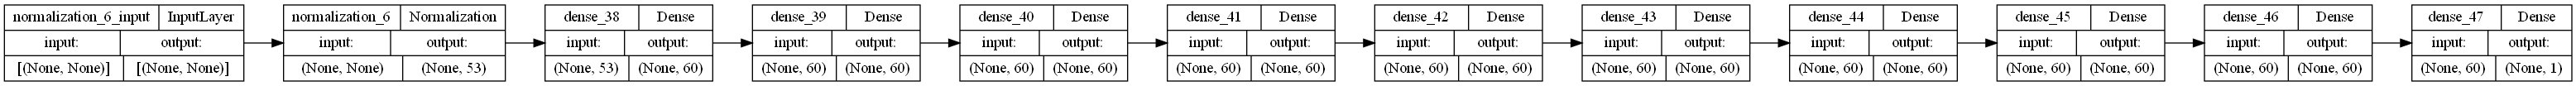

In [87]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

#### Train the model

In [88]:
history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = MAX_EPOCHS,
    validation_data = validate_ds,
    verbose = 1)

Epoch 1/1000
606/606 [==============================] - 2s 1ms/step - loss: 1.2619 - accuracy: 0.7358 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6168 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.6056 - accuracy: 0.7357 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6129 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5999 - accuracy: 0.7357 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6007 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5972 - accuracy: 0.7357 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5989 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/1000
606/606 [==========

Epoch 36/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5775 - accuracy: 0.7363 - precision: 0.5020 - recall: 0.0502 - val_loss: 0.5804 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5772 - accuracy: 0.7377 - precision: 0.5469 - recall: 0.0736 - val_loss: 0.5802 - val_accuracy: 0.7333 - val_precision: 0.4917 - val_recall: 0.1382
Epoch 38/1000
606/606 [==============================] - 1s 994us/step - loss: 0.5766 - accuracy: 0.7367 - precision: 0.5086 - recall: 0.0807 - val_loss: 0.5775 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/1000
606/606 [==============================] - 1s 996us/step - loss: 0.5763 - accuracy: 0.7373 - precision: 0.5187 - recall: 0.0705 - val_loss: 0.5779 - val_accuracy: 0.7325 - val_precision: 0.4834 - val_recall: 0.1134
Epoch 40/1000
606/606 [==============================] - 1s 1ms/step - l

Epoch 107/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5693 - accuracy: 0.7382 - precision: 0.5284 - recall: 0.1104 - val_loss: 0.5705 - val_accuracy: 0.7383 - val_precision: 0.5354 - val_recall: 0.1056
Epoch 108/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5666 - accuracy: 0.7386 - precision: 0.4966 - recall: 0.0861 - val_loss: 0.5714 - val_accuracy: 0.7354 - val_precision: 0.5057 - val_recall: 0.1366
Epoch 109/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5707 - accuracy: 0.7390 - precision: 0.5514 - recall: 0.1262 - val_loss: 0.5718 - val_accuracy: 0.7424 - val_precision: 0.6234 - val_recall: 0.0745
Epoch 110/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5702 - accuracy: 0.7412 - precision: 0.5508 - recall: 0.1101 - val_loss: 0.5715 - val_accuracy: 0.7304 - val_precision: 0.4793 - val_recall: 0.1801
Epoch 111/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5698 - a

Epoch 143/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5677 - accuracy: 0.7398 - precision: 0.5343 - recall: 0.1156 - val_loss: 0.5890 - val_accuracy: 0.7296 - val_precision: 0.4846 - val_recall: 0.2935
Epoch 144/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5680 - accuracy: 0.7398 - precision: 0.5270 - recall: 0.1072 - val_loss: 0.5709 - val_accuracy: 0.7370 - val_precision: 0.5183 - val_recall: 0.1320
Epoch 145/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5690 - accuracy: 0.7381 - precision: 0.5289 - recall: 0.1278 - val_loss: 0.5892 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 146/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5679 - accuracy: 0.7405 - precision: 0.5362 - recall: 0.1102 - val_loss: 0.5719 - val_accuracy: 0.7403 - val_precision: 0.5714 - val_recall: 0.0870
Epoch 147/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.

Epoch 214/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.7403 - precision: 0.5438 - recall: 0.1373 - val_loss: 0.5695 - val_accuracy: 0.7325 - val_precision: 0.4906 - val_recall: 0.2019
Epoch 215/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5648 - accuracy: 0.7409 - precision: 0.5194 - recall: 0.1058 - val_loss: 0.5951 - val_accuracy: 0.7288 - val_precision: 0.4845 - val_recall: 0.3401
Epoch 216/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5706 - accuracy: 0.7341 - precision: 0.5079 - recall: 0.1055 - val_loss: 0.5683 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 217/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5649 - accuracy: 0.7394 - precision: 0.5217 - recall: 0.1180 - val_loss: 0.5677 - val_accuracy: 0.7358 - val_precision: 0.5116 - val_recall: 0.1025
Epoch 218/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.

Epoch 250/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5694 - accuracy: 0.7408 - precision: 0.5497 - recall: 0.1362 - val_loss: 0.5762 - val_accuracy: 0.7325 - val_precision: 0.4917 - val_recall: 0.2298
Epoch 251/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5645 - accuracy: 0.7395 - precision: 0.5194 - recall: 0.1183 - val_loss: 0.5692 - val_accuracy: 0.7362 - val_precision: 0.5094 - val_recall: 0.1677
Epoch 252/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5659 - accuracy: 0.7418 - precision: 0.5362 - recall: 0.1266 - val_loss: 0.5721 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 253/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5661 - accuracy: 0.7424 - precision: 0.5570 - recall: 0.1424 - val_loss: 0.5719 - val_accuracy: 0.7337 - val_precision: 0.4954 - val_recall: 0.1677
Epoch 254/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.

Epoch 286/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5649 - accuracy: 0.7438 - precision: 0.5473 - recall: 0.1252 - val_loss: 0.5672 - val_accuracy: 0.7378 - val_precision: 0.5270 - val_recall: 0.1211
Epoch 287/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5683 - accuracy: 0.7376 - precision: 0.5224 - recall: 0.1200 - val_loss: 0.5673 - val_accuracy: 0.7337 - val_precision: 0.4953 - val_recall: 0.1646
Epoch 288/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5667 - accuracy: 0.7386 - precision: 0.5393 - recall: 0.1378 - val_loss: 0.5799 - val_accuracy: 0.7255 - val_precision: 0.4743 - val_recall: 0.3152
Epoch 289/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.7403 - precision: 0.5377 - recall: 0.1294 - val_loss: 0.5744 - val_accuracy: 0.7387 - val_precision: 0.5556 - val_recall: 0.0776
Epoch 290/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5670 - a

Epoch 322/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5648 - accuracy: 0.7391 - precision: 0.5245 - recall: 0.1128 - val_loss: 0.5667 - val_accuracy: 0.7391 - val_precision: 0.5455 - val_recall: 0.1025
Epoch 323/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.7428 - precision: 0.5649 - recall: 0.1296 - val_loss: 0.5764 - val_accuracy: 0.7383 - val_precision: 0.5634 - val_recall: 0.0621
Epoch 324/1000
606/606 [==============================] - 1s 988us/step - loss: 0.5689 - accuracy: 0.7379 - precision: 0.5274 - recall: 0.1346 - val_loss: 0.5671 - val_accuracy: 0.7387 - val_precision: 0.5397 - val_recall: 0.1056
Epoch 325/1000
606/606 [==============================] - 1s 988us/step - loss: 0.5681 - accuracy: 0.7396 - precision: 0.5331 - recall: 0.1102 - val_loss: 0.5676 - val_accuracy: 0.7358 - val_precision: 0.5140 - val_recall: 0.0854
Epoch 326/1000
606/606 [==============================] - 1s 984us/step - loss: 0.56

Epoch 358/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5674 - accuracy: 0.7375 - precision: 0.5122 - recall: 0.1191 - val_loss: 0.5886 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 359/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5663 - accuracy: 0.7372 - precision: 0.5197 - recall: 0.1380 - val_loss: 0.5699 - val_accuracy: 0.7300 - val_precision: 0.4784 - val_recall: 0.1894
Epoch 360/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5672 - accuracy: 0.7415 - precision: 0.5436 - recall: 0.1278 - val_loss: 0.5697 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 361/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5622 - accuracy: 0.7425 - precision: 0.5332 - recall: 0.1141 - val_loss: 0.5704 - val_accuracy: 0.7345 - val_precision: 0.5000 - val_recall: 0.1786
Epoch 362/1000
606/606 [==============================] - 1s 1ms/step - 

Epoch 429/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5650 - accuracy: 0.7377 - precision: 0.5164 - recall: 0.1409 - val_loss: 0.5733 - val_accuracy: 0.7370 - val_precision: 0.5577 - val_recall: 0.0450
Epoch 430/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.7405 - precision: 0.5310 - recall: 0.1191 - val_loss: 0.5675 - val_accuracy: 0.7374 - val_precision: 0.5271 - val_recall: 0.1056
Epoch 431/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5643 - accuracy: 0.7406 - precision: 0.5213 - recall: 0.1134 - val_loss: 0.5656 - val_accuracy: 0.7354 - val_precision: 0.5109 - val_recall: 0.0730
Epoch 432/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5673 - accuracy: 0.7388 - precision: 0.5350 - recall: 0.1365 - val_loss: 0.5665 - val_accuracy: 0.7399 - val_precision: 0.5619 - val_recall: 0.0916
Epoch 433/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5697 - a

Epoch 465/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5601 - accuracy: 0.7418 - precision: 0.5254 - recall: 0.1305 - val_loss: 0.5728 - val_accuracy: 0.7292 - val_precision: 0.4784 - val_recall: 0.2236
Epoch 466/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.7394 - precision: 0.5352 - recall: 0.1228 - val_loss: 0.5696 - val_accuracy: 0.7391 - val_precision: 0.5753 - val_recall: 0.0652
Epoch 467/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5641 - accuracy: 0.7393 - precision: 0.5320 - recall: 0.1343 - val_loss: 0.5667 - val_accuracy: 0.7374 - val_precision: 0.5229 - val_recall: 0.1242
Epoch 468/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5641 - accuracy: 0.7375 - precision: 0.5081 - recall: 0.1165 - val_loss: 0.5676 - val_accuracy: 0.7350 - val_precision: 0.5028 - val_recall: 0.1382
Epoch 469/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5680 - a

Epoch 501/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5683 - accuracy: 0.7388 - precision: 0.5270 - recall: 0.1272 - val_loss: 0.5821 - val_accuracy: 0.7246 - val_precision: 0.4694 - val_recall: 0.2857
Epoch 502/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5618 - accuracy: 0.7421 - precision: 0.5360 - recall: 0.1345 - val_loss: 0.5795 - val_accuracy: 0.7222 - val_precision: 0.4621 - val_recall: 0.2842
Epoch 503/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5715 - accuracy: 0.7365 - precision: 0.5272 - recall: 0.1311 - val_loss: 0.5771 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 504/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5632 - accuracy: 0.7433 - precision: 0.5480 - recall: 0.1321 - val_loss: 0.5679 - val_accuracy: 0.7362 - val_precision: 0.5143 - val_recall: 0.1118
Epoch 505/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.

Epoch 537/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5673 - accuracy: 0.7372 - precision: 0.5319 - recall: 0.1416 - val_loss: 0.5660 - val_accuracy: 0.7325 - val_precision: 0.4889 - val_recall: 0.1708
Epoch 538/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5664 - accuracy: 0.7410 - precision: 0.5416 - recall: 0.1234 - val_loss: 0.5678 - val_accuracy: 0.7362 - val_precision: 0.5101 - val_recall: 0.1568
Epoch 539/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5615 - accuracy: 0.7437 - precision: 0.5401 - recall: 0.1236 - val_loss: 0.5659 - val_accuracy: 0.7387 - val_precision: 0.5385 - val_recall: 0.1087
Epoch 540/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5627 - accuracy: 0.7408 - precision: 0.5290 - recall: 0.1325 - val_loss: 0.5700 - val_accuracy: 0.7374 - val_precision: 0.5376 - val_recall: 0.0776
Epoch 541/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5678 - a

Epoch 573/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5702 - accuracy: 0.7358 - precision: 0.5227 - recall: 0.1023 - val_loss: 0.5659 - val_accuracy: 0.7395 - val_precision: 0.5508 - val_recall: 0.1009
Epoch 574/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5622 - accuracy: 0.7419 - precision: 0.5420 - recall: 0.1462 - val_loss: 0.5723 - val_accuracy: 0.7387 - val_precision: 0.5568 - val_recall: 0.0761
Epoch 575/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5677 - accuracy: 0.7400 - precision: 0.5455 - recall: 0.1314 - val_loss: 0.5664 - val_accuracy: 0.7403 - val_precision: 0.5729 - val_recall: 0.0854
Epoch 576/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5604 - accuracy: 0.7405 - precision: 0.5183 - recall: 0.1174 - val_loss: 0.5750 - val_accuracy: 0.7275 - val_precision: 0.4762 - val_recall: 0.2640
Epoch 577/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5650 - a

Epoch 609/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5606 - accuracy: 0.7428 - precision: 0.5281 - recall: 0.1320 - val_loss: 0.5667 - val_accuracy: 0.7345 - val_precision: 0.5000 - val_recall: 0.1351
Epoch 610/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5648 - accuracy: 0.7412 - precision: 0.5385 - recall: 0.1354 - val_loss: 0.5659 - val_accuracy: 0.7354 - val_precision: 0.5064 - val_recall: 0.1227
Epoch 611/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5679 - accuracy: 0.7390 - precision: 0.5372 - recall: 0.1330 - val_loss: 0.5726 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 612/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5648 - accuracy: 0.7382 - precision: 0.5314 - recall: 0.1426 - val_loss: 0.5746 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 613/1000
606/606 [==============================] - 1s 1ms/step - 

Epoch 645/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5653 - accuracy: 0.7384 - precision: 0.5438 - recall: 0.1329 - val_loss: 0.5657 - val_accuracy: 0.7358 - val_precision: 0.5102 - val_recall: 0.1165
Epoch 646/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5686 - accuracy: 0.7379 - precision: 0.5418 - recall: 0.1398 - val_loss: 0.5656 - val_accuracy: 0.7354 - val_precision: 0.5071 - val_recall: 0.1102
Epoch 647/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5586 - accuracy: 0.7423 - precision: 0.5221 - recall: 0.1357 - val_loss: 0.5693 - val_accuracy: 0.7366 - val_precision: 0.5258 - val_recall: 0.0792
Epoch 648/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.7374 - precision: 0.5315 - recall: 0.1288 - val_loss: 0.5658 - val_accuracy: 0.7387 - val_precision: 0.5481 - val_recall: 0.0885
Epoch 649/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5636 - a

Epoch 681/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5671 - accuracy: 0.7377 - precision: 0.5416 - recall: 0.1438 - val_loss: 0.6142 - val_accuracy: 0.6801 - val_precision: 0.4162 - val_recall: 0.5093
Epoch 682/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5664 - accuracy: 0.7398 - precision: 0.5330 - recall: 0.1245 - val_loss: 0.5665 - val_accuracy: 0.7362 - val_precision: 0.5156 - val_recall: 0.1025
Epoch 683/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5624 - accuracy: 0.7399 - precision: 0.5174 - recall: 0.1143 - val_loss: 0.5676 - val_accuracy: 0.7345 - val_precision: 0.5000 - val_recall: 0.1755
Epoch 684/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5620 - accuracy: 0.7417 - precision: 0.5388 - recall: 0.1531 - val_loss: 0.5669 - val_accuracy: 0.7362 - val_precision: 0.5213 - val_recall: 0.0761
Epoch 685/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5672 - a

Epoch 717/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5652 - accuracy: 0.7425 - precision: 0.5543 - recall: 0.1478 - val_loss: 0.5701 - val_accuracy: 0.7395 - val_precision: 0.5833 - val_recall: 0.0652
Epoch 718/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5637 - accuracy: 0.7415 - precision: 0.5367 - recall: 0.1261 - val_loss: 0.5675 - val_accuracy: 0.7325 - val_precision: 0.4894 - val_recall: 0.1786
Epoch 719/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5596 - accuracy: 0.7430 - precision: 0.5302 - recall: 0.1320 - val_loss: 0.5722 - val_accuracy: 0.7370 - val_precision: 0.5283 - val_recall: 0.0870
Epoch 720/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5653 - accuracy: 0.7410 - precision: 0.5547 - recall: 0.1413 - val_loss: 0.5735 - val_accuracy: 0.7350 - val_precision: 0.5060 - val_recall: 0.0652
Epoch 721/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5648 - a

Epoch 753/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5681 - accuracy: 0.7388 - precision: 0.5423 - recall: 0.1554 - val_loss: 0.5646 - val_accuracy: 0.7370 - val_precision: 0.5300 - val_recall: 0.0823
Epoch 754/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5625 - accuracy: 0.7397 - precision: 0.5234 - recall: 0.1186 - val_loss: 0.5694 - val_accuracy: 0.7374 - val_precision: 0.5385 - val_recall: 0.0761
Epoch 755/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5639 - accuracy: 0.7383 - precision: 0.5218 - recall: 0.1331 - val_loss: 0.5648 - val_accuracy: 0.7362 - val_precision: 0.5122 - val_recall: 0.1304
Epoch 756/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5636 - accuracy: 0.7406 - precision: 0.5236 - recall: 0.1157 - val_loss: 0.5677 - val_accuracy: 0.7362 - val_precision: 0.5145 - val_recall: 0.1102
Epoch 757/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5632 - a

Epoch 789/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5636 - accuracy: 0.7408 - precision: 0.5378 - recall: 0.1251 - val_loss: 0.5769 - val_accuracy: 0.7312 - val_precision: 0.4896 - val_recall: 0.2919
Epoch 790/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5652 - accuracy: 0.7387 - precision: 0.5297 - recall: 0.1387 - val_loss: 0.5663 - val_accuracy: 0.7341 - val_precision: 0.4972 - val_recall: 0.1366
Epoch 791/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5615 - accuracy: 0.7440 - precision: 0.5441 - recall: 0.1193 - val_loss: 0.5809 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 792/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5680 - accuracy: 0.7374 - precision: 0.5332 - recall: 0.1378 - val_loss: 0.5666 - val_accuracy: 0.7354 - val_precision: 0.5051 - val_recall: 0.1537
Epoch 793/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.

Epoch 825/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5633 - accuracy: 0.7400 - precision: 0.5147 - recall: 0.1106 - val_loss: 0.5742 - val_accuracy: 0.7317 - val_precision: 0.4875 - val_recall: 0.2127
Epoch 826/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5646 - accuracy: 0.7397 - precision: 0.5363 - recall: 0.1350 - val_loss: 0.5650 - val_accuracy: 0.7370 - val_precision: 0.5183 - val_recall: 0.1320
Epoch 827/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5660 - accuracy: 0.7395 - precision: 0.5266 - recall: 0.1334 - val_loss: 0.5663 - val_accuracy: 0.7383 - val_precision: 0.5344 - val_recall: 0.1087
Epoch 828/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5628 - accuracy: 0.7401 - precision: 0.5356 - recall: 0.1450 - val_loss: 0.5666 - val_accuracy: 0.7312 - val_precision: 0.4806 - val_recall: 0.1537
Epoch 829/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5628 - a

Epoch 861/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5665 - accuracy: 0.7403 - precision: 0.5416 - recall: 0.1429 - val_loss: 0.5657 - val_accuracy: 0.7383 - val_precision: 0.5398 - val_recall: 0.0947
Epoch 862/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5617 - accuracy: 0.7419 - precision: 0.5320 - recall: 0.1340 - val_loss: 0.5674 - val_accuracy: 0.7387 - val_precision: 0.5490 - val_recall: 0.0870
Epoch 863/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5622 - accuracy: 0.7425 - precision: 0.5385 - recall: 0.1401 - val_loss: 0.5637 - val_accuracy: 0.7387 - val_precision: 0.5357 - val_recall: 0.1165
Epoch 864/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5674 - accuracy: 0.7364 - precision: 0.5204 - recall: 0.1361 - val_loss: 0.5748 - val_accuracy: 0.7205 - val_precision: 0.4557 - val_recall: 0.2717
Epoch 865/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5623 - a

Epoch 897/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5635 - accuracy: 0.7421 - precision: 0.5527 - recall: 0.1249 - val_loss: 0.5681 - val_accuracy: 0.7271 - val_precision: 0.4717 - val_recall: 0.2329
Epoch 898/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5625 - accuracy: 0.7405 - precision: 0.5197 - recall: 0.1219 - val_loss: 0.5673 - val_accuracy: 0.7358 - val_precision: 0.5140 - val_recall: 0.0854
Epoch 899/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5656 - accuracy: 0.7391 - precision: 0.5367 - recall: 0.1388 - val_loss: 0.5722 - val_accuracy: 0.7321 - val_precision: 0.4878 - val_recall: 0.1863
Epoch 900/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5636 - accuracy: 0.7398 - precision: 0.5333 - recall: 0.1404 - val_loss: 0.5663 - val_accuracy: 0.7345 - val_precision: 0.5000 - val_recall: 0.1258
Epoch 901/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5652 - a

Epoch 933/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5660 - accuracy: 0.7406 - precision: 0.5465 - recall: 0.1392 - val_loss: 0.5653 - val_accuracy: 0.7378 - val_precision: 0.5206 - val_recall: 0.1568
Epoch 934/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5656 - accuracy: 0.7398 - precision: 0.5393 - recall: 0.1373 - val_loss: 0.5690 - val_accuracy: 0.7370 - val_precision: 0.5385 - val_recall: 0.0652
Epoch 935/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5619 - accuracy: 0.7429 - precision: 0.5418 - recall: 0.1249 - val_loss: 0.5664 - val_accuracy: 0.7378 - val_precision: 0.5426 - val_recall: 0.0792
Epoch 936/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5639 - accuracy: 0.7423 - precision: 0.5430 - recall: 0.1238 - val_loss: 0.5715 - val_accuracy: 0.7345 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 937/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.

Epoch 969/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5631 - accuracy: 0.7407 - precision: 0.5400 - recall: 0.1354 - val_loss: 0.5774 - val_accuracy: 0.7399 - val_precision: 0.5823 - val_recall: 0.0714
Epoch 970/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5655 - accuracy: 0.7393 - precision: 0.5465 - recall: 0.1439 - val_loss: 0.5773 - val_accuracy: 0.7292 - val_precision: 0.4848 - val_recall: 0.3214
Epoch 971/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5629 - accuracy: 0.7408 - precision: 0.5123 - recall: 0.1197 - val_loss: 0.5756 - val_accuracy: 0.7284 - val_precision: 0.4792 - val_recall: 0.2686
Epoch 972/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5655 - accuracy: 0.7389 - precision: 0.5360 - recall: 0.1172 - val_loss: 0.5661 - val_accuracy: 0.7362 - val_precision: 0.5101 - val_recall: 0.1568
Epoch 973/1000
606/606 [==============================] - 1s 1ms/step - loss: 0.5628 - a

## Evaluation

Binary cross entropy plot

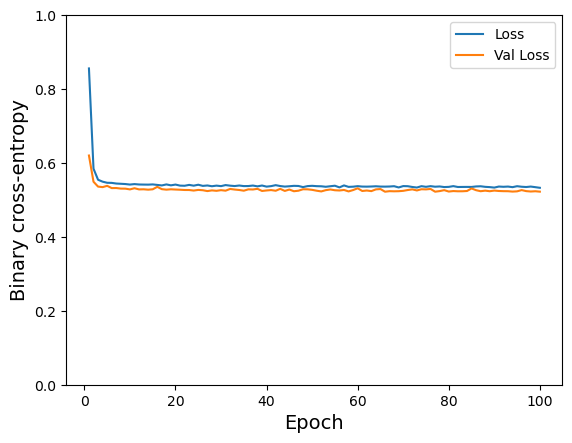

In [12]:
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['loss'], label = 'Loss')
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['val_loss'], label = 'Val Loss')
plt.ylabel('Binary cross-entropy', size = 14)
plt.xlabel('Epoch', size = 14)
plt.ylim([0., 1.])
plt.legend();

In [13]:
y_pred = model.predict(test_ds, verbose=0)

In [14]:
features, targets = tuple(zip(*test_ds))
y_true = np.array(targets)

M&F model AUC score: 0.7040212997512438


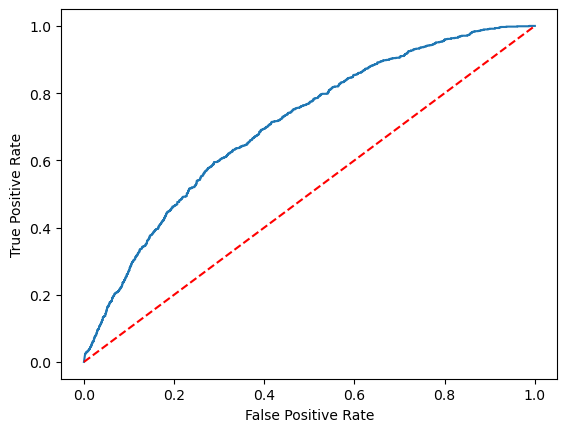

In [15]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)  # test dataset
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print(f'M&F model AUC score: {roc_auc_score(y_true, y_pred)}')

## Hyperparameter tuning

In [31]:
class MyHyperModel(kt.HyperModel) :
    def __init__(self, normalizer):
        self.normalizer = normalizer
    
    def build(self, hp) : 
        model = tf.keras.Sequential()
        model.add(self.normalizer)
        # model.add(tf.keras.layers.Input(53))
        
        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 32-512
        hp_units = hp.Int('units', min_value=10, max_value=160, step=10)
        hp_layers = hp.Int('layers', min_value = 1, max_value = 6, step = 1)
        hp_l2reg = hp.Choice('lambda', values = [1e-4, 1e-3, 1e-2, 1e-1])
        for l in range(hp_layers):
            model.add(tf.keras.layers.Dense(units = hp_units, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(hp_l2reg)))
            model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

        return model
    
    
    def fit(self, hp, model, x, *args, **kwargs) :
        
        return model.fit(x, *args, **kwargs)

In [34]:
tuner = kt.BayesianOptimization(hypermodel=MyHyperModel(normalizer),
                     objective = "val_accuracy", #optimize val acc
                     overwrite=True,  #overwrite previous results
                     directory='hyperband_search_dir', #Saving dir
                     project_name='CardiacClassifiers')

In [35]:
tuner.search(x = train_ds, steps_per_epoch = STEPS_PER_EPOCH, epochs=50, validation_data = validate_ds)

Trial 10 Complete [00h 00m 26s]
val_accuracy: 0.7353668808937073

Best val_accuracy So Far: 0.738664448261261
Total elapsed time: 00h 05m 44s
INFO:tensorflow:Oracle triggered exit


In [36]:
best_hps = tuner.get_best_hyperparameters(1)
h_model = MyHyperModel(normalizer)
model = h_model.build(best_hps[0])

In [37]:
MAX_EPOCHS = 200
history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = MAX_EPOCHS,
    validation_data = validate_ds,
    verbose = 1)

Epoch 1/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5800 - accuracy: 0.7287 - precision: 0.4445 - recall: 0.1518 - val_loss: 0.5848 - val_accuracy: 0.7246 - val_precision: 0.3971 - val_recall: 0.0554
Epoch 2/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5465 - accuracy: 0.7428 - precision: 0.5288 - recall: 0.1286 - val_loss: 0.5583 - val_accuracy: 0.7307 - val_precision: 0.4922 - val_recall: 0.1951
Epoch 3/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5393 - accuracy: 0.7411 - precision: 0.5234 - recall: 0.1185 - val_loss: 0.5580 - val_accuracy: 0.7323 - val_precision: 0.5000 - val_recall: 0.1099
Epoch 4/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5377 - accuracy: 0.7426 - precision: 0.5417 - recall: 0.1026 - val_loss: 0.5504 - val_accuracy: 0.7296 - val_precision: 0.4750 - val_recall: 0.0975
Epoch 5/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5358 - accuracy: 0.7436

530/530 [==============================] - 1s 1ms/step - loss: 0.5271 - accuracy: 0.7437 - precision: 0.5377 - recall: 0.1241 - val_loss: 0.5476 - val_accuracy: 0.7304 - val_precision: 0.4748 - val_recall: 0.0678
Epoch 74/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5267 - accuracy: 0.7428 - precision: 0.5351 - recall: 0.1287 - val_loss: 0.5462 - val_accuracy: 0.7381 - val_precision: 0.5393 - val_recall: 0.1478
Epoch 75/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5230 - accuracy: 0.7477 - precision: 0.5627 - recall: 0.1362 - val_loss: 0.5531 - val_accuracy: 0.7321 - val_precision: 0.4968 - val_recall: 0.0801
Epoch 76/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5265 - accuracy: 0.7427 - precision: 0.5435 - recall: 0.1278 - val_loss: 0.5462 - val_accuracy: 0.7365 - val_precision: 0.5385 - val_recall: 0.1078
Epoch 77/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5260 - accuracy: 0.7437 - preci

530/530 [==============================] - 1s 1ms/step - loss: 0.5243 - accuracy: 0.7444 - precision: 0.5491 - recall: 0.1615 - val_loss: 0.5473 - val_accuracy: 0.7310 - val_precision: 0.4874 - val_recall: 0.0996
Epoch 146/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5258 - accuracy: 0.7423 - precision: 0.5285 - recall: 0.1339 - val_loss: 0.5523 - val_accuracy: 0.7340 - val_precision: 0.5300 - val_recall: 0.0544
Epoch 147/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5249 - accuracy: 0.7421 - precision: 0.5330 - recall: 0.1360 - val_loss: 0.5511 - val_accuracy: 0.7378 - val_precision: 0.5360 - val_recall: 0.1530
Epoch 148/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5218 - accuracy: 0.7465 - precision: 0.5392 - recall: 0.1363 - val_loss: 0.5508 - val_accuracy: 0.7340 - val_precision: 0.5158 - val_recall: 0.1006
Epoch 149/200
530/530 [==============================] - 1s 1ms/step - loss: 0.5287 - accuracy: 0.7417 - p

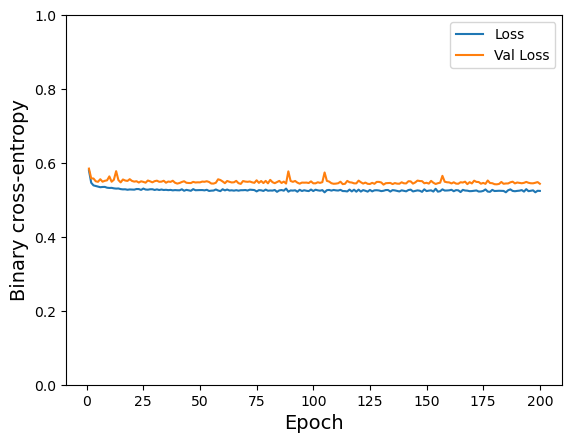

In [38]:
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['loss'], label = 'Loss')
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['val_loss'], label = 'Val Loss')
plt.ylabel('Binary cross-entropy', size = 14)
plt.xlabel('Epoch', size = 14)
plt.ylim([0., 1.])
plt.legend();

## Male and female heart NNs

In [33]:
csv_file = 'HeartDiseaseLarge.csv'
dataframe = pd.read_csv(csv_file)

dataframe = dataframe.drop(columns = ['eid']) # Drop the eid, disease lists, and old disease vs. healthy coding
df0 = dataframe.loc[dataframe['p31'] == 0]
df1 = dataframe.loc[dataframe['p31'] == 1]
features0 = df0.copy()
features1 = df1.copy()
features0.drop(columns = ['p31'])
features1.drop(columns = ['p31'])
n_patients0 = len(features0.index) # Number of all patients
n_patients1 = len(features1.index) 

target0 = features0.pop('HeartDisease') # OUTPUT
target1 = features1.pop('HeartDisease')

tf.convert_to_tensor(features0) # INPUT features (tensor)
tf.convert_to_tensor(features1) # INPUT features (tensor)

normalizer0 = tf.keras.layers.Normalization(axis = -1)
normalizer0.adapt(features0)

normalizer1 = tf.keras.layers.Normalization(axis = -1)
normalizer1.adapt(features1)

### Female

In [52]:
# Constants for training/testing and batching
N_VALIDATE = int(0.1 * n_patients0)  # test size is same as validation size; does not need to be specified
N_TRAIN = int(0.8 * n_patients0)  # train + validate + test = 1
BUFFER_SIZE = n_patients0
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
MAX_EPOCHS = 200

In [53]:
# Build dataset object from the tensor (HERE ALSO SHUFFLED?)
ds = tf.data.Dataset.from_tensor_slices((features0, target0))
ds_shuffled = ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False)

# Split into training, validation, and testing sets
train_ds = ds_shuffled.take(N_TRAIN).cache()
validate_ds = ds_shuffled.skip(N_TRAIN).take(N_VALIDATE).cache()
test_ds = ds_shuffled.skip(N_TRAIN).skip(N_VALIDATE).cache()

# Shuffle and batch the training and validation sets (no shuffling for validation set)
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration = True).repeat().batch(BATCH_SIZE)

In [54]:
model0 = tf.keras.Sequential([
    normalizer0,
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

model0.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

history = model0.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = MAX_EPOCHS,
    validation_data = validate_ds,
    verbose = 1)

Epoch 1/200
315/315 [==============================] - 1s 1ms/step - loss: 0.9117 - accuracy: 0.7651 - precision: 0.1722 - recall: 0.0240 - val_loss: 0.6240 - val_accuracy: 0.8198 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
315/315 [==============================] - 0s 759us/step - loss: 0.5922 - accuracy: 0.7846 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4971 - val_accuracy: 0.8198 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
315/315 [==============================] - 0s 762us/step - loss: 0.5248 - accuracy: 0.7848 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4662 - val_accuracy: 0.8198 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
315/315 [==============================] - 0s 755us/step - loss: 0.5082 - accuracy: 0.7846 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4569 - val_accuracy: 0.8198 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
315/315 [=================

Epoch 71/200
315/315 [==============================] - 0s 746us/step - loss: 0.4865 - accuracy: 0.7887 - precision: 0.5979 - recall: 0.0535 - val_loss: 0.4418 - val_accuracy: 0.8230 - val_precision: 0.5667 - val_recall: 0.0749
Epoch 72/200
315/315 [==============================] - 0s 746us/step - loss: 0.4860 - accuracy: 0.7852 - precision: 0.5194 - recall: 0.0492 - val_loss: 0.4499 - val_accuracy: 0.8238 - val_precision: 0.5676 - val_recall: 0.0925
Epoch 73/200
315/315 [==============================] - 0s 749us/step - loss: 0.4879 - accuracy: 0.7873 - precision: 0.5793 - recall: 0.0388 - val_loss: 0.4472 - val_accuracy: 0.8230 - val_precision: 0.5435 - val_recall: 0.1101
Epoch 74/200
315/315 [==============================] - 0s 765us/step - loss: 0.4866 - accuracy: 0.7887 - precision: 0.6085 - recall: 0.0530 - val_loss: 0.4412 - val_accuracy: 0.8214 - val_precision: 0.5278 - val_recall: 0.0837
Epoch 75/200
315/315 [==============================] - 0s 769us/step - loss: 0.4860 - a

Epoch 107/200
315/315 [==============================] - 0s 759us/step - loss: 0.4857 - accuracy: 0.7873 - precision: 0.5500 - recall: 0.0458 - val_loss: 0.4400 - val_accuracy: 0.8238 - val_precision: 0.5806 - val_recall: 0.0793
Epoch 108/200
315/315 [==============================] - 0s 778us/step - loss: 0.4844 - accuracy: 0.7883 - precision: 0.5612 - recall: 0.0615 - val_loss: 0.4405 - val_accuracy: 0.8246 - val_precision: 0.6364 - val_recall: 0.0617
Epoch 109/200
315/315 [==============================] - 0s 756us/step - loss: 0.4866 - accuracy: 0.7858 - precision: 0.5446 - recall: 0.0533 - val_loss: 0.4507 - val_accuracy: 0.8238 - val_precision: 0.5490 - val_recall: 0.1233
Epoch 110/200
315/315 [==============================] - 0s 752us/step - loss: 0.4867 - accuracy: 0.7876 - precision: 0.5411 - recall: 0.0519 - val_loss: 0.4363 - val_accuracy: 0.8238 - val_precision: 0.6190 - val_recall: 0.0573
Epoch 111/200
315/315 [==============================] - 0s 759us/step - loss: 0.486

Epoch 143/200
315/315 [==============================] - 0s 749us/step - loss: 0.4863 - accuracy: 0.7882 - precision: 0.5822 - recall: 0.0603 - val_loss: 0.4360 - val_accuracy: 0.8206 - val_precision: 0.5263 - val_recall: 0.0441
Epoch 144/200
315/315 [==============================] - 0s 759us/step - loss: 0.4819 - accuracy: 0.7896 - precision: 0.5582 - recall: 0.0647 - val_loss: 0.4415 - val_accuracy: 0.8222 - val_precision: 0.5484 - val_recall: 0.0749
Epoch 145/200
315/315 [==============================] - 0s 746us/step - loss: 0.4874 - accuracy: 0.7859 - precision: 0.5664 - recall: 0.0585 - val_loss: 0.4406 - val_accuracy: 0.8222 - val_precision: 0.5484 - val_recall: 0.0749
Epoch 146/200
315/315 [==============================] - 0s 743us/step - loss: 0.4846 - accuracy: 0.7881 - precision: 0.5363 - recall: 0.0617 - val_loss: 0.4444 - val_accuracy: 0.8198 - val_precision: 0.5000 - val_recall: 0.0529
Epoch 147/200
315/315 [==============================] - 0s 754us/step - loss: 0.488

Epoch 179/200
315/315 [==============================] - 0s 746us/step - loss: 0.4823 - accuracy: 0.7883 - precision: 0.5327 - recall: 0.0494 - val_loss: 0.4368 - val_accuracy: 0.8230 - val_precision: 0.5625 - val_recall: 0.0793
Epoch 180/200
315/315 [==============================] - 0s 746us/step - loss: 0.4829 - accuracy: 0.7899 - precision: 0.5519 - recall: 0.0621 - val_loss: 0.4363 - val_accuracy: 0.8206 - val_precision: 0.5135 - val_recall: 0.0837
Epoch 181/200
315/315 [==============================] - 0s 746us/step - loss: 0.4852 - accuracy: 0.7851 - precision: 0.5433 - recall: 0.0744 - val_loss: 0.4448 - val_accuracy: 0.8222 - val_precision: 0.5294 - val_recall: 0.1189
Epoch 182/200
315/315 [==============================] - 0s 744us/step - loss: 0.4851 - accuracy: 0.7885 - precision: 0.5720 - recall: 0.0641 - val_loss: 0.4344 - val_accuracy: 0.8246 - val_precision: 0.6667 - val_recall: 0.0529
Epoch 183/200
315/315 [==============================] - 0s 743us/step - loss: 0.486

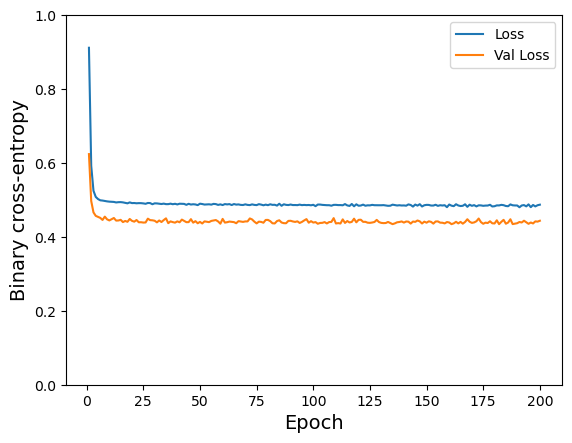

In [58]:
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['loss'], label = 'Loss')
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['val_loss'], label = 'Val Loss')
plt.ylabel('Binary cross-entropy', size = 14)
plt.xlabel('Epoch', size = 14)
plt.ylim([0., 1.])
plt.legend();

In [55]:
y_pred = model0.predict(test_ds, verbose=0)

In [56]:
features, targets = tuple(zip(*test_ds))
y_true = np.array(targets)

M&F model AUC score: 0.6701598613626185


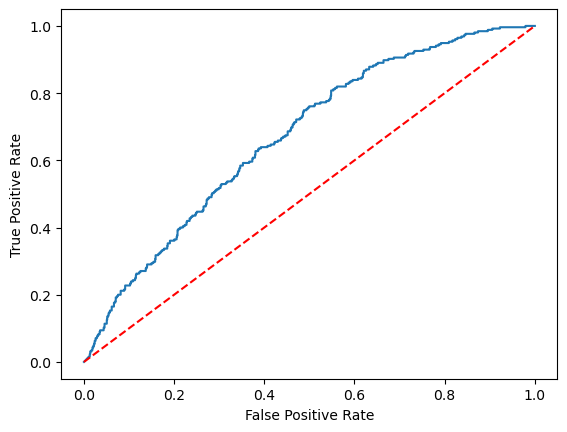

In [57]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)  # test dataset
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print(f'M&F model AUC score: {roc_auc_score(y_true, y_pred)}')

### Male

In [24]:
# Constants for training/testing and batching
N_VALIDATE = int(0.15 * n_patients1)  # test size is same as validation size; does not need to be specified
N_TRAIN = int(0.7 * n_patients1)  # train + validate + test = 1
BUFFER_SIZE = n_patients1
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
MAX_EPOCHS = 200

In [25]:
# Build dataset object from the tensor (HERE ALSO SHUFFLED?)
ds = tf.data.Dataset.from_tensor_slices((features1, target1))
ds_shuffled = ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration = False)

# Split into training, validation, and testing sets
train_ds = ds_shuffled.take(N_TRAIN).cache()
validate_ds = ds_shuffled.skip(N_TRAIN).take(N_VALIDATE).cache()
test_ds = ds_shuffled.skip(N_TRAIN).skip(N_VALIDATE).cache()

# Shuffle and batch the training and validation sets (no shuffling for validation set)
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration = True).repeat().batch(BATCH_SIZE)

In [26]:
model1 = tf.keras.Sequential([
    normalizer1,
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(20, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

model1.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

history = model1.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = MAX_EPOCHS,
    validation_data = validate_ds,
    verbose = 1)

Epoch 1/200
254/254 [==============================] - 1s 1ms/step - loss: 1.0226 - accuracy: 0.6710 - precision: 0.3226 - recall: 0.0191 - val_loss: 0.8089 - val_accuracy: 0.7002 - val_precision: 0.6957 - val_recall: 0.0300
Epoch 2/200
254/254 [==============================] - 0s 793us/step - loss: 0.7228 - accuracy: 0.6844 - precision: 0.5852 - recall: 0.0695 - val_loss: 0.6649 - val_accuracy: 0.7025 - val_precision: 0.6667 - val_recall: 0.0488
Epoch 3/200
254/254 [==============================] - 0s 791us/step - loss: 0.6402 - accuracy: 0.6848 - precision: 0.5753 - recall: 0.0888 - val_loss: 0.6214 - val_accuracy: 0.6991 - val_precision: 0.6207 - val_recall: 0.0338
Epoch 4/200
254/254 [==============================] - 0s 795us/step - loss: 0.6124 - accuracy: 0.6842 - precision: 0.5442 - recall: 0.1060 - val_loss: 0.6079 - val_accuracy: 0.7008 - val_precision: 0.5510 - val_recall: 0.1013
Epoch 5/200
254/254 [==============================] - 0s 799us/step - loss: 0.6029 - accuracy

Epoch 37/200
254/254 [==============================] - 0s 780us/step - loss: 0.5830 - accuracy: 0.6970 - precision: 0.5609 - recall: 0.2478 - val_loss: 0.5911 - val_accuracy: 0.6962 - val_precision: 0.5104 - val_recall: 0.0919
Epoch 38/200
254/254 [==============================] - 0s 779us/step - loss: 0.5848 - accuracy: 0.6964 - precision: 0.5774 - recall: 0.2442 - val_loss: 0.5903 - val_accuracy: 0.6962 - val_precision: 0.5045 - val_recall: 0.2101
Epoch 39/200
254/254 [==============================] - 0s 815us/step - loss: 0.5860 - accuracy: 0.6932 - precision: 0.5659 - recall: 0.2221 - val_loss: 0.5896 - val_accuracy: 0.6945 - val_precision: 0.4977 - val_recall: 0.2008
Epoch 40/200
254/254 [==============================] - 0s 795us/step - loss: 0.5829 - accuracy: 0.6977 - precision: 0.5684 - recall: 0.2527 - val_loss: 0.5905 - val_accuracy: 0.7002 - val_precision: 0.5171 - val_recall: 0.2552
Epoch 41/200
254/254 [==============================] - 0s 779us/step - loss: 0.5864 - a

Epoch 73/200
254/254 [==============================] - 0s 799us/step - loss: 0.5762 - accuracy: 0.6991 - precision: 0.5582 - recall: 0.2404 - val_loss: 0.5864 - val_accuracy: 0.7019 - val_precision: 0.5333 - val_recall: 0.1801
Epoch 74/200
254/254 [==============================] - 0s 783us/step - loss: 0.5849 - accuracy: 0.6976 - precision: 0.5846 - recall: 0.2223 - val_loss: 0.5914 - val_accuracy: 0.6888 - val_precision: 0.4817 - val_recall: 0.2720
Epoch 75/200
254/254 [==============================] - 0s 787us/step - loss: 0.5791 - accuracy: 0.7021 - precision: 0.5861 - recall: 0.2812 - val_loss: 0.5896 - val_accuracy: 0.7031 - val_precision: 0.5422 - val_recall: 0.1689
Epoch 76/200
254/254 [==============================] - 0s 787us/step - loss: 0.5820 - accuracy: 0.7000 - precision: 0.5911 - recall: 0.2707 - val_loss: 0.5943 - val_accuracy: 0.6876 - val_precision: 0.4804 - val_recall: 0.2983
Epoch 77/200
254/254 [==============================] - 0s 796us/step - loss: 0.5834 - a

Epoch 109/200
254/254 [==============================] - 0s 783us/step - loss: 0.5777 - accuracy: 0.7046 - precision: 0.5883 - recall: 0.2479 - val_loss: 0.5971 - val_accuracy: 0.6888 - val_precision: 0.4861 - val_recall: 0.3621
Epoch 110/200
254/254 [==============================] - 0s 789us/step - loss: 0.5772 - accuracy: 0.7031 - precision: 0.5835 - recall: 0.2896 - val_loss: 0.5910 - val_accuracy: 0.6951 - val_precision: 0.5000 - val_recall: 0.2627
Epoch 111/200
254/254 [==============================] - 0s 799us/step - loss: 0.5822 - accuracy: 0.7005 - precision: 0.5842 - recall: 0.2301 - val_loss: 0.5877 - val_accuracy: 0.7054 - val_precision: 0.5429 - val_recall: 0.2139
Epoch 112/200
254/254 [==============================] - 0s 795us/step - loss: 0.5774 - accuracy: 0.7051 - precision: 0.5917 - recall: 0.2667 - val_loss: 0.5890 - val_accuracy: 0.7019 - val_precision: 0.5236 - val_recall: 0.2495
Epoch 113/200
254/254 [==============================] - 0s 787us/step - loss: 0.579

Epoch 145/200
254/254 [==============================] - 0s 787us/step - loss: 0.5776 - accuracy: 0.7066 - precision: 0.5971 - recall: 0.2780 - val_loss: 0.5889 - val_accuracy: 0.6934 - val_precision: 0.4946 - val_recall: 0.2589
Epoch 146/200
254/254 [==============================] - 0s 787us/step - loss: 0.5789 - accuracy: 0.7013 - precision: 0.5784 - recall: 0.2428 - val_loss: 0.5889 - val_accuracy: 0.6979 - val_precision: 0.5092 - val_recall: 0.2608
Epoch 147/200
254/254 [==============================] - 0s 795us/step - loss: 0.5769 - accuracy: 0.7068 - precision: 0.5952 - recall: 0.2859 - val_loss: 0.5886 - val_accuracy: 0.7031 - val_precision: 0.5486 - val_recall: 0.1482
Epoch 148/200
254/254 [==============================] - 0s 775us/step - loss: 0.5796 - accuracy: 0.6980 - precision: 0.5735 - recall: 0.2568 - val_loss: 0.5877 - val_accuracy: 0.6928 - val_precision: 0.4917 - val_recall: 0.2233
Epoch 149/200
254/254 [==============================] - 0s 783us/step - loss: 0.572

Epoch 181/200
254/254 [==============================] - 0s 775us/step - loss: 0.5832 - accuracy: 0.7005 - precision: 0.5895 - recall: 0.2900 - val_loss: 0.5991 - val_accuracy: 0.6756 - val_precision: 0.4610 - val_recall: 0.3771
Epoch 182/200
254/254 [==============================] - 0s 775us/step - loss: 0.5766 - accuracy: 0.7026 - precision: 0.5812 - recall: 0.2365 - val_loss: 0.5895 - val_accuracy: 0.6939 - val_precision: 0.4956 - val_recall: 0.2120
Epoch 183/200
254/254 [==============================] - 0s 767us/step - loss: 0.5761 - accuracy: 0.7088 - precision: 0.6003 - recall: 0.2806 - val_loss: 0.5907 - val_accuracy: 0.6945 - val_precision: 0.4980 - val_recall: 0.2383
Epoch 184/200
254/254 [==============================] - 0s 783us/step - loss: 0.5772 - accuracy: 0.6987 - precision: 0.5686 - recall: 0.2660 - val_loss: 0.5907 - val_accuracy: 0.6945 - val_precision: 0.4985 - val_recall: 0.3096
Epoch 185/200
254/254 [==============================] - 0s 787us/step - loss: 0.570

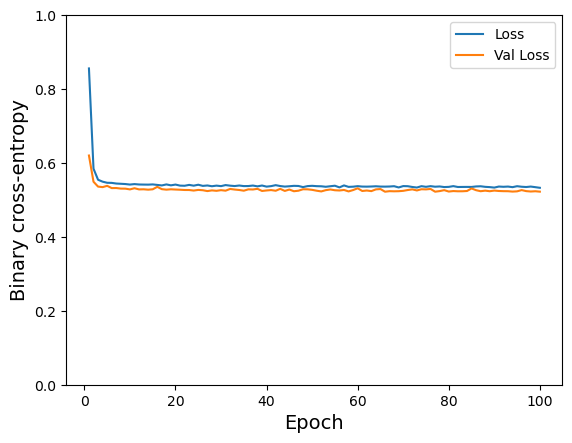

In [12]:
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['loss'], label = 'Loss')
plt.plot(np.arange(1, MAX_EPOCHS + 1), history.history['val_loss'], label = 'Val Loss')
plt.ylabel('Binary cross-entropy', size = 14)
plt.xlabel('Epoch', size = 14)
plt.ylim([0., 1.])
plt.legend();

In [27]:
y_pred = model1.predict(test_ds, verbose=0)

In [28]:
features, targets = tuple(zip(*test_ds))
y_true = np.array(targets)

M&F model AUC score: 0.6701393690293007


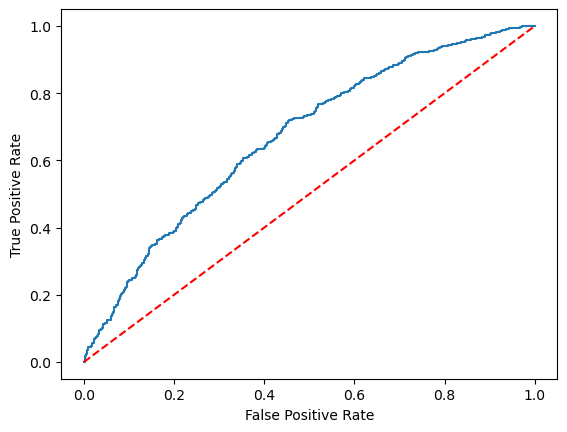

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)  # test dataset
plt.plot(fpr, tpr)
plt.plot(np.linspace(0,1, 100), np.linspace(0,1,100),'--r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print(f'M&F model AUC score: {roc_auc_score(y_true, y_pred)}')